# CONCEIVE AN APP FOR THE PUBLIC HEALTH AGENCY: EXPLORATION PHASE

<div style="width:100%;text-align: center;"> <img align=middle src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Nutri-score-A.svg/220px-Nutri-score-A.svg.png" alt="Heat beating" style="height:200px;margin-top:3rem;"> </div>

The Nutri-Score, also known as the 5-Colour Nutrition label or 5-CNL, is a nutritional rating system that was selected by the French government in March 2017 to be displayed on food products after it was compared against several labels proposed by industry or retailers. It relies on the computation of a nutrient profiling system derived from the United Kingdom Food Standards Agency nutrient profiling system (FSA score).
When compared with other Front-of-Package labels, Nutri-Score emerged as the most efficient in conveying information on the nutritional quality of foods.

Objectif:

In [16]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # linear algebra
import pandas as pd               # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp                # numerical integration, interpolation, optimizatio & statistics
import scipy.stats as stats
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python
from matplotlib.collections import LineCollection
import statsmodels.formula.api as smf
import statsmodels.api as sm


# Import the outpout file from the cleaning phases
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_data_cleaned = pd.read_csv('../input/datacleaned/cleaned_file.csv', low_memory=False, encoding='utf-_8')
df_data_cleaned = df_data_cleaned.drop(['Unnamed: 0'], axis=1)
df_data_cleaned['nutriscore_grade'] = df_data_cleaned['nutriscore_grade'].str.upper()
df_data_cleaned.head(2)

/kaggle/input/datacleaned/cleaned_file.csv


,code,url,creator,product_name,quantity,brands,ingredients_text,nutriscore_score,nutriscore_grade,pnns_groups_1,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,Countries
0,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,moutarde au moût de raisin,100g,courte paille,eau graines de téguments de moutarde vinaigre ...,18.0,D,Fat and sauces,...,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.60,1.840,France
1,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,Salade de carottes râpées,NaN,NaN,NaN,1.0,B,Composite foods,...,134.0,0.3,0.1,5.3,3.9,NaN,0.9,0.42,0.168,France


## NUTRIGRADE & NUTRISCORE OVERVIEW

A Nutri-Score for a particular food item is given in one of five classification letters, with 'A' being a preferable score and 'E' being a detrimental score. The calculation of the score involves seven different parameters of nutrient information per 100g of food which are usually available on food packagings.

High content of fruits and vegetables, fibers, protein and healthy oils (rapeseed, walnut and olive oils, rule added in 2019 promote a preferable score, while high content of energy, sugar, saturated fatty acids, and sodium promote a detrimental score. In addition to the general calculation rules applied to most types of food, there are special rules for cheese, for “added fats” (fats that are meant as ingredients, such as vegetable oils or butter), and for beverages.

Focusing on Nutriscore & Nutrigrade first, the below boxplot shows good correlation between both parameters which means few errors on those combined parameters have been input by users.

In [17]:
# Dataframe creation about the official relationship between Nutrigrade & Nutriscore
data = {'Solid Foods': ['Min to -1', '0-2', '3-10', '11-18', '19-max'],
        'Beverages': ['Waters', 'Min-1', '2-5', '6-9', '10-max'],
        'Nutri Grade': ['A', 'B', 'C', 'D', 'E']}
df_nutrigrade = pd.DataFrame(data)
df_nutrigrade.set_index('Nutri Grade', inplace=True)
df_nutrigrade

,Solid Foods,Beverages
Nutri Grade,,
A,Min to -1,Waters
B,0-2,Min-1
C,3-10,2-5
D,11-18,6-9
E,19-max,10-max


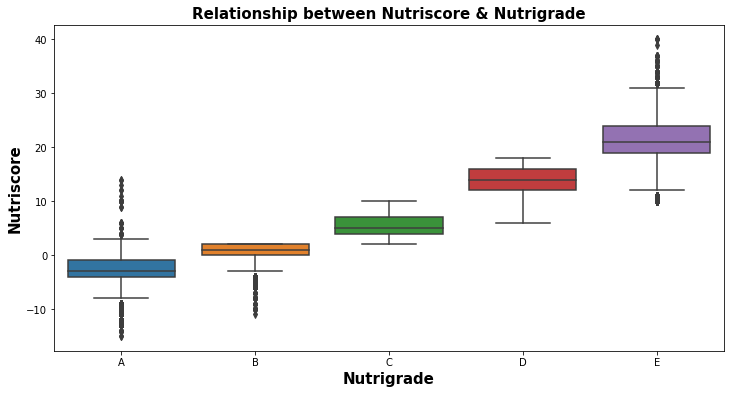

In [18]:
plt.figure(figsize=(12, 6))
rel = sns.boxplot(x='nutriscore_grade', y='nutriscore_score', data=df_data_cleaned.sort_values('nutriscore_score'))
rel.axes.set_title("Relationship between Nutriscore & Nutrigrade", fontsize=15, weight = "bold")
rel.set_xlabel("Nutrigrade",fontsize=15, weight = "bold")
rel.set_ylabel("Nutriscore",fontsize=15, weight = "bold")
rel.tick_params(labelsize=10)
plt.show()

__NUTRISCORE/GRADE DISTRIBUTION IN THE DATASET__

Text(0, 0.5, 'Number of products')

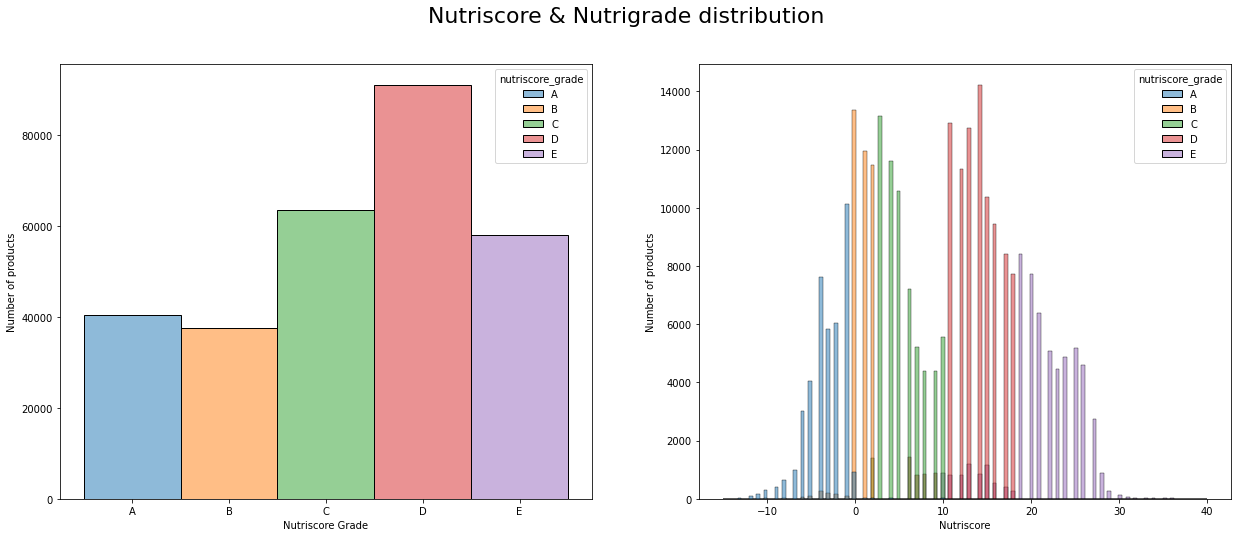

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(21,8)) 
fig.suptitle(r"Nutriscore & Nutrigrade distribution", fontsize=22)

sns.histplot(data=df_data_cleaned.sort_values("nutriscore_grade"), x="nutriscore_grade", hue="nutriscore_grade", ax=axes[0])
axes[0].set_xlabel("Nutriscore Grade")
axes[0].set_ylabel("Number of products")

sns.histplot(data=df_data_cleaned.sort_values("nutriscore_grade"), x="nutriscore_score", hue="nutriscore_grade", ax=axes[1])
axes[1].set_xlabel("Nutriscore")
axes[1].set_ylabel("Number of products")

Most products (+80k) are classified into the D grade while grade A & B products are the less represented (<40k).

__FOCUS ON CATEGORIES OF PRODUCT: PNNS GROUPS__

All these products are divided into few categories which can help us see more details about the classification.
Classification of individual products is made in 2 main National Nutrition and Health Program (PNNS) groups.

In [20]:
# Estimation of the number of products available per category in PNNS Group 1

cat_counts1 = df_data_cleaned['pnns_groups_1'].value_counts(dropna=True, sort=True)
df_cat_counts1 = pd.DataFrame(cat_counts1)
df_cat_counts1.index.name = 'Categories'
df_cat_counts1.columns = ['Number of records']
df_cat_counts1

,Number of records
Categories,
Sugary snacks,55840
Fish Meat Eggs,45664
Milk and dairy products,35710
Cereals and potatoes,26564
Composite foods,25810
unknown,23740
Beverages,20052
Fat and sauces,19543
Salty snacks,18917


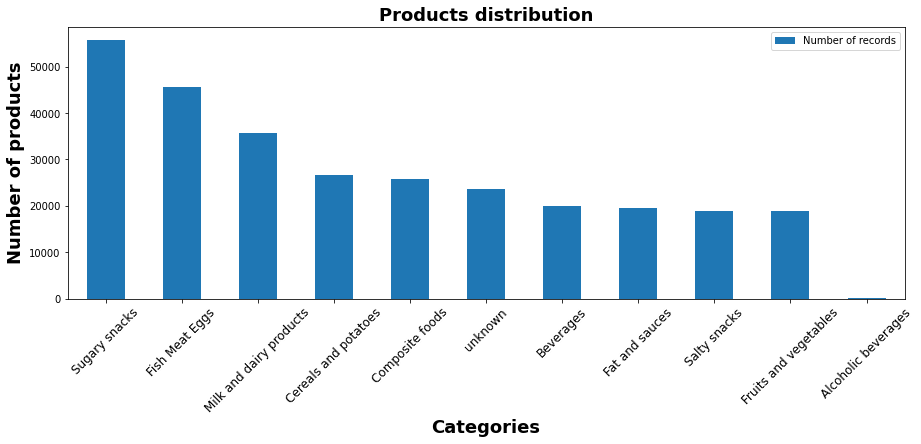

In [21]:
plt.rcParams["figure.figsize"] = (15,5)
res1 = df_cat_counts1.plot(kind='bar')
plt.title('Products distribution', fontsize = 18, weight = 'bold')
plt.xlabel ('Categories', fontsize=18, weight = 'bold')
plt.ylabel ('Number of products', fontsize=18, weight = 'bold')
res1.set_xticklabels (res1.get_xmajorticklabels(), rotation = 45, fontsize = 12, va = "top")
plt.show()

__IMPACT OF PRODUCTS CATEGORY ON NUTRISCORE__

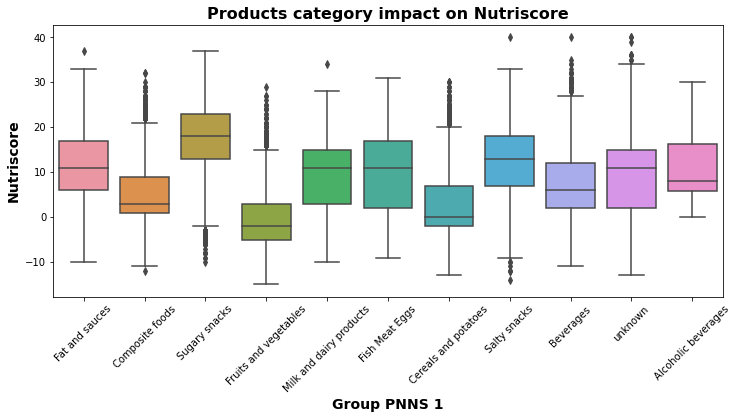

In [22]:
fig = plt.figure(figsize=(12,5))
ax = sns.boxplot(data=df_data_cleaned, x='pnns_groups_1', y='nutriscore_score')
plt.xlabel ('Group PNNS 1', fontsize=14, weight = 'bold')
plt.ylabel ('Nutriscore', fontsize=14, weight = 'bold')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Products category impact on Nutriscore", weight = "bold", fontsize = 16)
plt.show()

__COMPOSITION OF PRODUCTS__

Each individual product is composed by key factors: Nutrients.<br>
Nutrients are compounds in foods essential to life and health, providing us with energy, the building blocks for repair and growth and substances necessary to regulate chemical processes. Those vary in quantity in each product.
As Open Food Facts is a free, online and crowdsourced database of food products, there are a lot of suspicious data input by users that we need to deal with.

1) Nutrients are based on a 100gr scale so any values above 100gr and below 0gr are surely erroneus<br>
2) Any value of satured fat higher than fat is not possible for a determined product<br>
3) Any value of sodium higher than salt is not possible for a determined product<br>
4) The fat + saturated fat values should stay within 100gr for a determined product<br>
5) Any energy values higher than 4000 kcal is likely to be erroneus

In [23]:
# Set up boundaries for nutrients values within the dataset

var_names = [ 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
             'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']

nutrients = df_data_cleaned[var_names]
df_data_cleaned = df_data_cleaned[~((nutrients > 100) | (nutrients < 0)).any(axis=1)]

df_data_cleaned = df_data_cleaned.loc[~((nutrients == 0) | (nutrients.isnull())).all(axis=1)]

df_data_cleaned = df_data_cleaned[~((nutrients['saturated-fat_100g'] > nutrients['fat_100g']) 
                                | (nutrients['sodium_100g'] > nutrients['salt_100g']))]

df_data_cleaned = df_data_cleaned[(nutrients['fat_100g'] + nutrients['saturated-fat_100g'] ) < 100]

df_data_cleaned = df_data_cleaned[(df_data_cleaned['energy_100g'] < 4000)]
df_data_cleaned.to_csv('nutrients.csv')
round(df_data_cleaned.describe(), 2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,nutriscore_score,ecoscore_score_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,281021.00,202608.00,281021.00,281021.00,281021.00,280933.00,281021.00,101084.00,281021.00,281016.00,281016.00
mean,9.48,46.19,1120.06,13.79,5.40,25.34,12.67,2.94,9.36,1.06,0.42
std,8.79,26.37,719.51,14.83,6.93,26.60,18.56,4.43,9.10,2.37,0.95
min,-15.00,-23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,27.00,491.00,1.50,0.30,2.50,0.70,0.50,2.50,0.10,0.04
50%,10.00,42.00,1054.00,8.70,2.20,12.50,3.33,1.80,6.70,0.63,0.25
75%,16.00,67.00,1648.00,23.00,8.20,49.90,17.00,3.70,14.00,1.33,0.53
max,40.00,124.00,3996.00,99.95,49.00,100.00,100.00,100.00,100.00,100.00,40.00


__DATA AVAILABLE FOR NUTRIENTS IN DATAFRAME__

In [24]:
# Creation of a special dataframe for nutrients + energy data in dataframe
var_name_ener = [ 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
                          'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g']
df_nutri = df_data_cleaned[var_name_ener]
df_non_nutri = df_data_cleaned[df_data_cleaned.columns.difference(['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
                          'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g'])]
available_data = df_nutri.notnull().sum() * 100 / len(df_nutri)
available_data_df = pd.DataFrame({'Column label': df_nutri.columns,
                                 'Existing data pct': available_data})
available_data_df.reset_index(drop=True, inplace=True)
available_data_df.sort_values('Existing data pct', ascending=False, inplace=True)
available_data_df.index = np.arange(1, len(available_data_df)+1)
available_data_df['Existing data pct'] = available_data_df['Existing data pct'].astype(float, errors = 'raise')
round(available_data_df, 2)


,Column label,Existing data pct
1,fat_100g,100.00
2,saturated-fat_100g,100.00
3,sugars_100g,100.00
4,proteins_100g,100.00
5,energy_100g,100.00
6,salt_100g,100.00
7,sodium_100g,100.00
8,carbohydrates_100g,99.97
9,fiber_100g,35.97


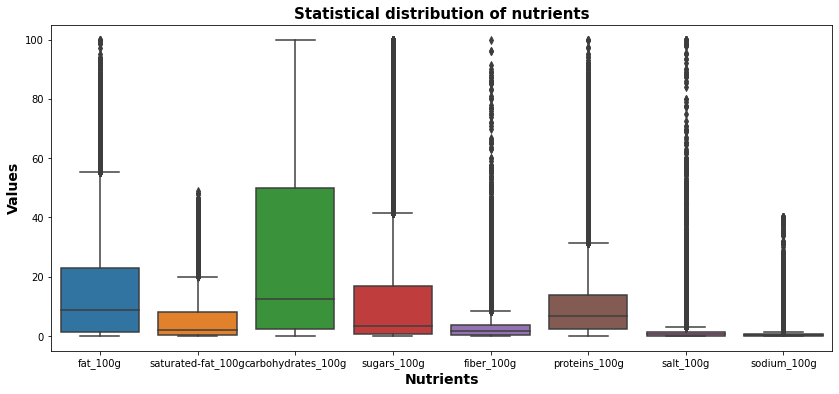

In [25]:
fig = plt.figure(figsize=(14,6))
ax = sns.boxplot(data=df_nutri.loc[:, df_nutri.columns != 'energy_100g']) #, showfliers = False)
ax.axes.set_title("Statistical distribution of nutrients", fontsize=15, weight = "bold")
ax.set_xlabel("Nutrients", fontsize=14, weight = "bold")
ax.set_ylabel("Values", fontsize=14, weight = "bold")
ax.tick_params(labelsize=10)
plt.show()

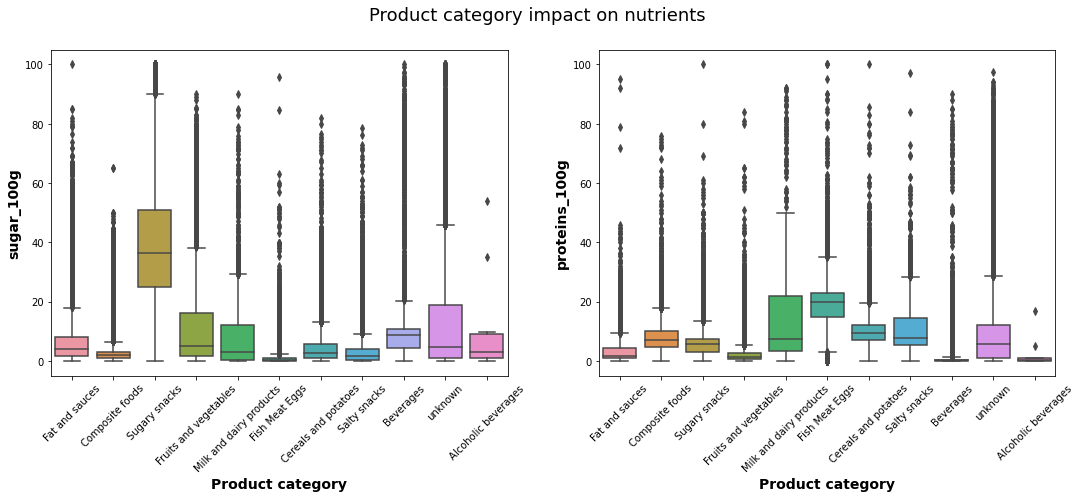

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18,6)) 
fig.suptitle(r"Product category impact on nutrients", fontsize=18)

sns.boxplot(data=df_data_cleaned, x='pnns_groups_1', y='sugars_100g', ax=axes[0])
axes[0].set_xlabel("Product category", fontsize=14, weight = "bold")
axes[0].set_ylabel("sugar_100g", fontsize=14, weight = "bold")
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(), fontsize = 10, rotation=45)

sns.boxplot(data=df_data_cleaned, x='pnns_groups_1', y='proteins_100g', ax=axes[1])
axes[1].set_xlabel("Product category", fontsize=14, weight = "bold")
axes[1].set_ylabel("proteins_100g", fontsize=14, weight = "bold")
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(), fontsize = 10, rotation=45)

plt.show()

__IDENTIFYING OUTLIERS WITH INTERQUANTILE RANGE (IQR)__

This technique uses the IQR scores to remove outliers. The rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.<br>
After this process, around 10k products over 290k products are removed.

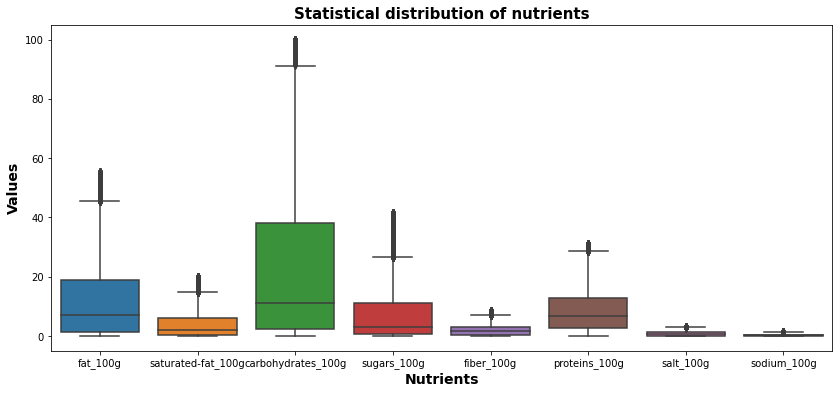

In [27]:
Q1 = df_nutri.quantile(0.25)
Q3 = df_nutri.quantile(0.75)
IQR = Q3 - Q1
df_out_nutri = df_nutri[~((df_nutri < (Q1 - 1.5 * IQR)) |(df_nutri > (Q3 + 1.5 * IQR))).any(axis=1)]

fig = plt.figure(figsize=(14,6))
ax = sns.boxplot(data=df_out_nutri.loc[:, df_out_nutri.columns != 'energy_100g']) #, showfliers = False)
ax.axes.set_title("Statistical distribution of nutrients", fontsize=15, weight = "bold")
ax.set_xlabel("Nutrients", fontsize=14, weight = "bold")
ax.set_ylabel("Values", fontsize=14, weight = "bold")
ax.tick_params(labelsize=10)
plt.show()

__DATAFRAME RECONSTRUCTION WITH NUTRIENTS OUTLIERS REMOVED__

In [28]:
merged = df_non_nutri.merge(df_out_nutri, left_index=True, right_index=True, how='inner')


In [29]:
#fig, axes = plt.subplots(1, 2, figsize=(18,6)) 
#fig.suptitle(r"Product category impact on nutrients", fontsize=18)

#sns.boxplot(data=merged, x='pnns_groups_1', y='sugars_100g', ax=axes[0])
#axes[0].set_xlabel("Product category", fontsize=14, weight = "bold")
#axes[0].set_ylabel("Values", fontsize=14, weight = "bold")
#axes[0].set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10, rotation=45)

#sns.boxplot(data=merged, x='pnns_groups_1', y='proteins_100g', ax=axes[1])
#axes[1].set_xlabel("Product category", fontsize=14, weight = "bold")
#axes[1].set_ylabel("Values", fontsize=14, weight = "bold")
#axes[1].set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10, rotation=45)

#plt.show()

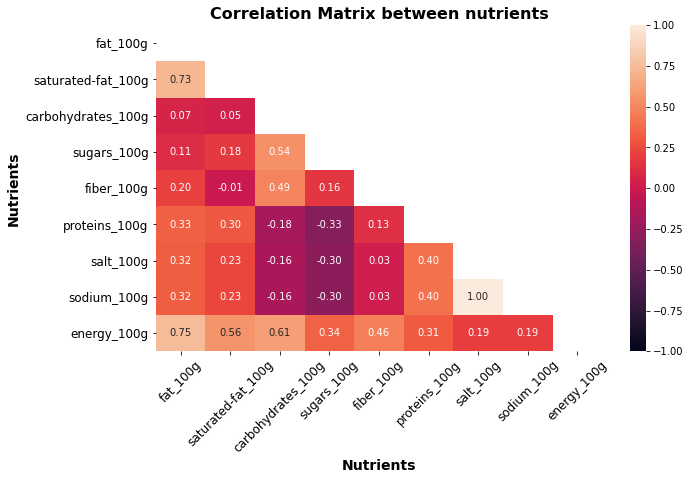

In [30]:

correlation_mat = df_out_nutri.corr()

plt.figure(figsize=(10,6))
tricor = np.triu(correlation_mat)
res = sns.heatmap(correlation_mat, vmin=-1, vmax=1, center= None, annot = True, fmt='.2f', annot_kws={"size": 10}, mask=tricor)
plt.title('Correlation Matrix between nutrients', fontsize = 16, weight = 'bold')
plt.xlabel ('Nutrients', fontsize=14, weight = 'bold')
plt.ylabel ('Nutrients', fontsize=14, weight = 'bold')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12, rotation=45)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12, rotation=0)

plt.show()

<Figure size 1080x360 with 0 Axes>

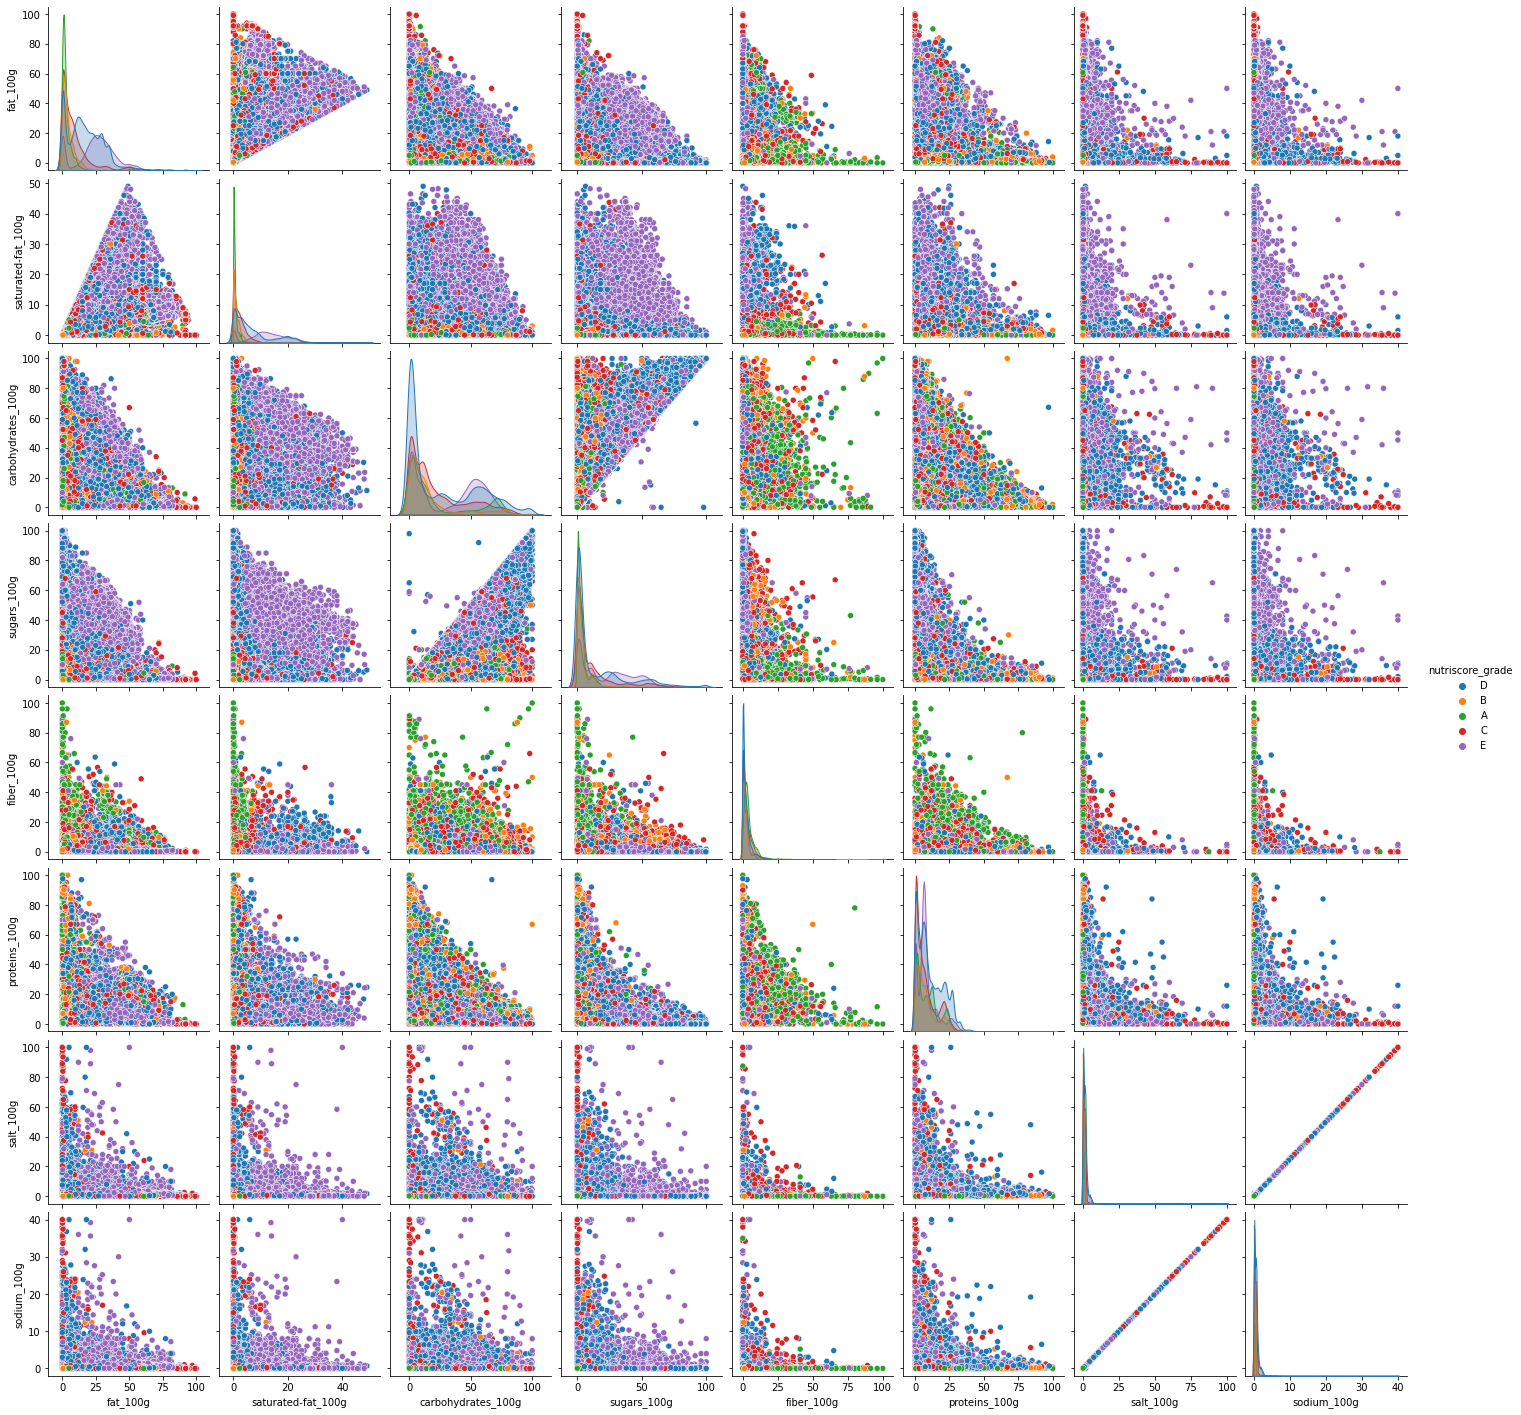

In [31]:
plt.figure()
sns.pairplot(df_data_cleaned, vars=var_names, hue = "nutriscore_grade")
plt.show()

__PCA__

In [32]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # 3 first factorial plans displayed i.e the first 6 componants
        if d2 < n_comp:

            # plot initialisation 
            fig, ax = plt.subplots(figsize=(7,6))

            # Limits of the plot fixed
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Arrows display
            # If more than 30 arrows, triangle not displayed
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Variable names displayed  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Circle display
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Plot limits definition
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        


def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Principal Component Values")
    plt.ylabel("Percentage Explained Variance")
    plt.title("Scree plot")
    plt.show(block=False)

In [33]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Illustr_var = le.fit_transform(df_data_cleaned['nutriscore_grade'])

#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#Illustr_var = encoder.fit_transform(Illustr_var)
#Illustr_var = Illustr_var.reshape((Illustr_var.shape[0],1))


Le premier tableau de resultats a regarder est le tableau des pourcentages d’inertie
correspondants aux diff´erentes valeurs propres, contenant aussi les pourcentages cumul´es associ´es :
ce tableau va permettre de choisir la dimension q retenue pour interpr´eter l’A.C.P.


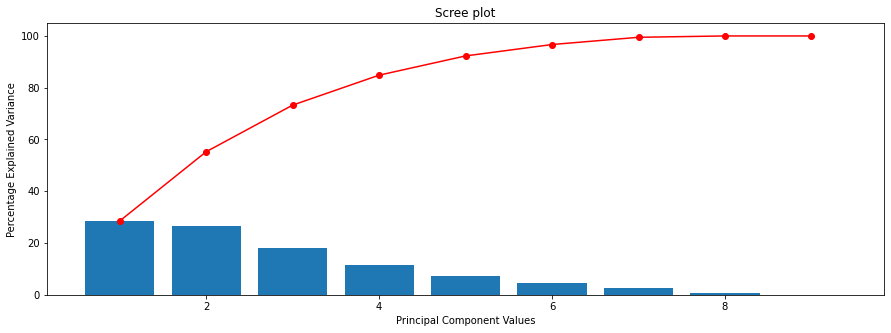

In [34]:
from sklearn import decomposition
from sklearn import preprocessing
#from functions import *

# choix du nombre de composantes à calculer
n_comp = 9

# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_data_cleaned[["energy_100g","proteins_100g","carbohydrates_100g","fat_100g",
                         "saturated-fat_100g","salt_100g","sodium_100g","sugars_100g","fiber_100g"]]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
#data_pca = data_pca.fillna()
X = data_pca.values
names = df_data_cleaned['nutriscore_grade'] #["idCours"] # ou data.index pour avoir les intitulés
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

plt.show()

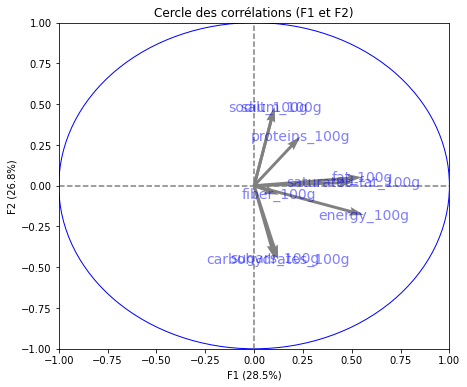

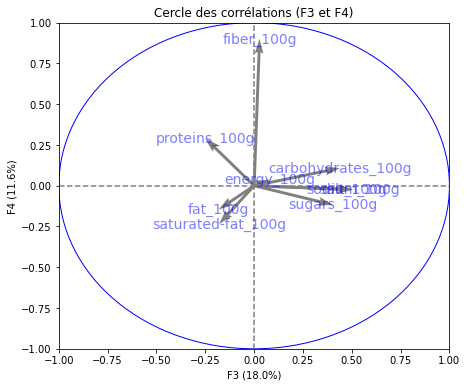

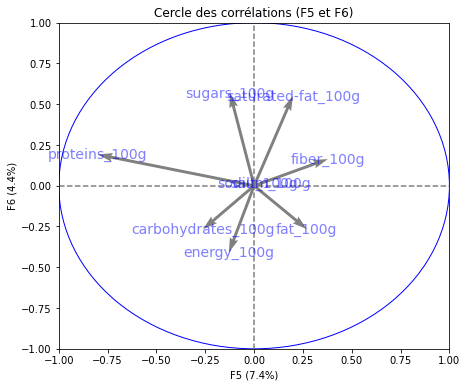

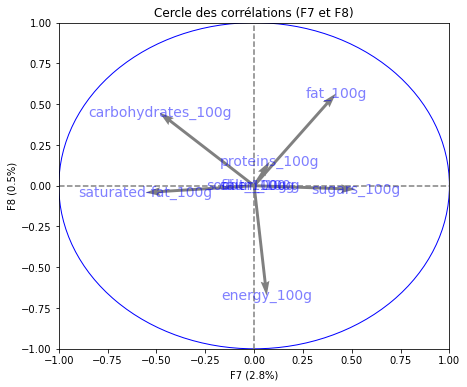

In [35]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5), (6,7)], labels = np.array(features))

In [36]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

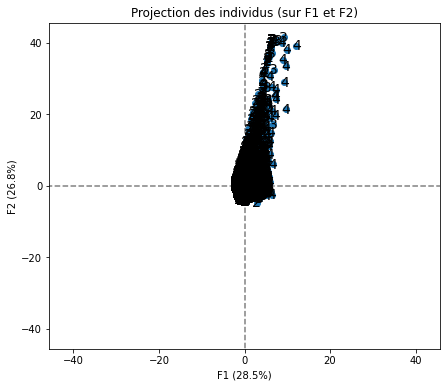

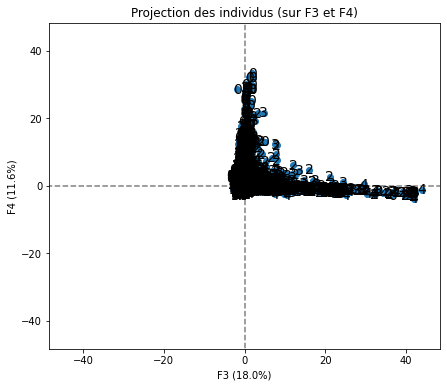

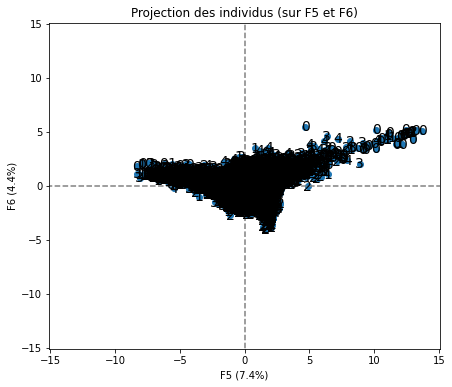

In [37]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], Illustr_var)

plt.show()

__ANOVA__

In [38]:
anova_table = smf.ols('proteins_100g~pnns_groups_1', data=merged).fit()
print(anova_table.summary())

                            OLS Regression Results                            
Dep. Variable:          proteins_100g   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                 2.019e+04
Date:                Wed, 28 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:02:53   Log-Likelihood:            -6.5684e+05
No. Observations:              212012   AIC:                         1.314e+06
Df Residuals:                  212001   BIC:                         1.314e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [39]:
sm.stats.anova_lm(anova_table, typ=2)

,sum_sq,df,F,PR(>F)
pnns_groups_1,5.804559e+06,10.0,20194.384219,0.0
Residual,6.093636e+06,212001.0,NaN,NaN


__LINEAR REGRESSION__

With outliers

In [40]:
y1 = df_data_cleaned['nutriscore_score'].values
X1 = df_data_cleaned[var_name_ener].fillna(0)


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1)
X1_scaled = scaler.transform(X1)

In [42]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.3)

In [43]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X1_train, y1_train)
dummy_pred = dummy_reg.predict(X1_test)

In [44]:
def metrics_model(y1_true, y1_pred):
    y1_true, y1_pred = np.array(y1_true), np.array(y1_pred)
    diff = y1_true - y1_pred
    mae = np.mean(abs(diff))
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    r2 = 1-(sum(diff**2)/sum((y1_true-np.mean(y1_true))**2))
    dict_metrics = {"Functions":["MAE", "MSE", "RMSE", "R²"], "Results":[mae, mse, rmse, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

dummy_metrics = metrics_model(y1_test, dummy_pred).rename(columns={'Results':'Baseline'})
dummy_metrics

,Functions,Baseline
0,MAE,7.589342
1,MSE,77.380661
2,RMSE,8.796628
3,R²,-0.000008


In [45]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X1_train, y1_train)
lr_pred = lr.predict(X1_test)
lr_metrics = metrics_model(y1_test, lr_pred).rename(columns={'Results':'LinearRegression'})
lr_metrics = pd.concat([dummy_metrics,lr_metrics['LinearRegression']], axis=1)
lr_metrics


,Functions,Baseline,LinearRegression
0,MAE,7.589342,3.992000
1,MSE,77.380661,25.291185
2,RMSE,8.796628,5.029034
3,R²,-0.000008,0.673156


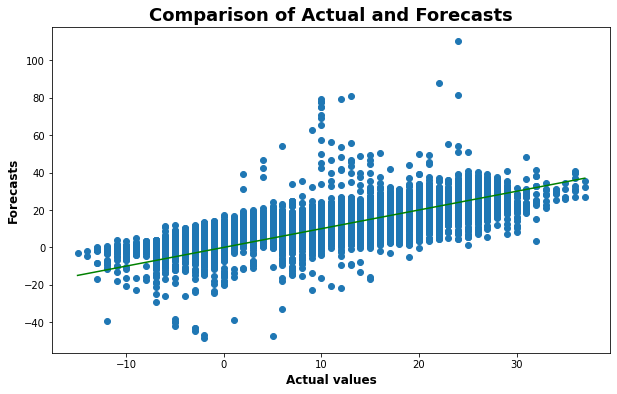

In [46]:
def plot_pred_true(y1_true, y1_pred):
    X1_plot = [y1_true.min(), y1_true.max()]
    fig = plt.figure(figsize=(10,6))
    plt.scatter(y1_true, y1_pred)
    plt.plot(X1_plot, X1_plot, color='g')
    plt.xlabel("Actual values", weight = "bold", fontsize = 12)
    plt.ylabel("Forecasts", weight = "bold", fontsize = 12)
    plt.title("Comparison of Actual and Forecasts", weight = "bold", fontsize=18)
    plt.show()
plot_pred_true(y1_true=y1_test, y1_pred=lr_pred)

In [56]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

nutrients1 = list(X1.columns)
numerical_transformer = StandardScaler()

cats = list(['pnns_groups_1', 'pnns_groups_2'])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=
                                 [('num', numerical_transformer, nutrients1),
                                  ('cat', categorical_transformer, cats)])

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])
df_data_cleaned = df_data_cleaned.fillna(0)
X3 = df_data_cleaned[nutrients + cats]
y3 = df_data_cleaned['nutriscore_score']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

pipeline_lr.fit(X3_train, y3_train)
plr_pred = pipeline_lr.predict(X3_test)

plr_metrics = metrics_model(y3_test, plr_pred).rename(columns={'Results':'LinearRegression pnns'})
plr_metrics = pd.concat([lr_metrics,plr_metrics['LinearRegression pnns']], axis=1)
round(plr_metrics, 3)

,Functions,Baseline,LinearRegression,LinearRegression pnns
0,MAE,7.589,3.992,2.817
1,MSE,77.381,25.291,14.130
2,RMSE,8.797,5.029,3.759
3,R²,-0.000,0.673,0.817


__LINEAR REGRESSION__
Without outliers

In [48]:
# Data Selection 
y = merged['nutriscore_score'].values
X = merged[var_name_ener].fillna(0)

In [49]:
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

The train-test split is a technique for evaluating the performance of a machine learning algorithm.<br>

Train Dataset: Used to fit the machine learning model.<br>
Test Dataset: Used to evaluate the fit machine learning model.<br>
The objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

In [50]:
# Splitting the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

The Dummy Regressor is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data. The sklearn library provides Dummy Regressor which is used to set up a baseline for comparing Linear Regression for instance.

In [51]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
dummy_pred = dummy_reg.predict(X_test)

__MODEL FIT METRICS__

To evaluate our regression model, we can calculate the distance between our forecast values and our actual value which yields to:

MAE is the sum of absolute differences between our target and predicted variables.<br>
MSE measures the average squared difference between the estimated values and the actual value.<br>
RMSE is the standard deviation of the residuals. <br>
RSS is the residuals sum of squares.<br>
R² is the coefficient of determination and evaluates the scatter of the data points around the fitted regression line.<br>

In [52]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def algo_model(y_actual, y_forecast):
    """Return metrics for model evaluation in regression"""
    
    y_actual, y_forecast = np.array(y_actual), np.array(y_forecast)
    mae = mean_absolute_error(y_actual, y_forecast)
    rss = np.sum((y_actual - y_forecast)**2)
    mse = mean_squared_error(y_actual, y_forecast)
    rmse = np.sqrt(mse)
    functions = {"Functions":["Min Absolute Error (MAE)", "Residual Sum of Squares (RSS)",
                              "Mean Squared Error (MSE)", "Residual Mean Squared Error (RMSE)",
                              "Coefficient of determination (R²)"],
                              "Results":[mae, rss, mse, rmse, r2_score(y_actual, y_forecast)]}
    df_stats = pd.DataFrame(functions) 
    return df_stats

dummy_metrics = algo_model(y_test, dummy_pred).rename(columns={'Results':'Baseline'})
round(dummy_metrics, 3)

,Functions,Baseline
0,Min Absolute Error (MAE),7.162
1,Residual Sum of Squares (RSS),2862602.471
2,Mean Squared Error (MSE),67.509
3,Residual Mean Squared Error (RMSE),8.216
4,Coefficient of determination (R²),-0.000


In [53]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train, y_train)
regr_forecast = regr.predict(X_test)
regr_metrics = algo_model(y_test, regr_forecast).rename(columns={'Results':'LinearRegression'})
regr_metrics = pd.concat([dummy_metrics,regr_metrics['LinearRegression']], axis=1)
round(regr_metrics, 2)

,Functions,Baseline,LinearRegression
0,Min Absolute Error (MAE),7.16,2.75
1,Residual Sum of Squares (RSS),2862602.47,587785.25
2,Mean Squared Error (MSE),67.51,13.86
3,Residual Mean Squared Error (RMSE),8.22,3.72
4,Coefficient of determination (R²),-0.00,0.79


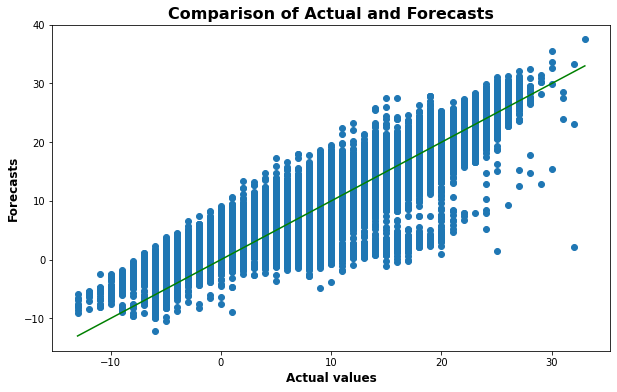

In [54]:
def forecast_comp(y_actual, y_forecast):
    X_plot = [y_actual.min(), y_actual.max()]
    fig = plt.figure(figsize=(10,6))
    plt.scatter(y_actual, y_forecast)
    plt.plot(X_plot, X_plot, color='g')
    plt.xlabel("Actual values", weight = "bold", fontsize=12)
    plt.ylabel("Forecasts", weight = "bold", fontsize=12)
    plt.title("Comparison of Actual and Forecasts", weight = "bold", fontsize=16)
    plt.show()
forecast_comp(y_actual=y_test, y_forecast = regr_forecast)

__SECOND REGRESSION__

In order to improve our linear regression, we'll incorporate categorical variables "pnns groups" and check if it gives values/improvement from our former linear regression.
A one hot encoding is a representation of categorical variables as binary vectors.
This first requires that the categorical values be mapped to integer values.
Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1. <br>


In [55]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

nutrients = list(X.columns)
numerical_transformer = StandardScaler()

cats = list(['pnns_groups_1', 'pnns_groups_2'])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=
                                 [('num', numerical_transformer, nutrients),
                                  ('cat', categorical_transformer, cats)])

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])
merged = merged.fillna(0)
X2 = merged[nutrients + cats]
y2 = merged['nutriscore_score']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=42)

pipeline_lr.fit(X2_train, y2_train)
plr_pred = pipeline_lr.predict(X2_test)

plr_metrics = algo_model(y2_test, plr_pred).rename(columns={'Results':'LinearRegression cat'})
plr_metrics = pd.concat([regr_metrics,plr_metrics['LinearRegression cat']], axis=1)
round(plr_metrics, 3)

,Functions,Baseline,LinearRegression,LinearRegression cat
0,Min Absolute Error (MAE),7.162,2.745,1.749
1,Residual Sum of Squares (RSS),2862602.471,587785.252,630645.890
2,Mean Squared Error (MSE),67.509,13.862,5.949
3,Residual Mean Squared Error (RMSE),8.216,3.723,2.439
4,Coefficient of determination (R²),-0.000,0.795,0.912
